Установим пакет missingpy, с помощью которого в дальнейшем будем заполнять пропуски.
Link: https://github.com/epsilon-machine/missingpy

In [0]:
!pip install missingpy

# Imports

In [0]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, Imputer
from sklearn.pipeline import make_pipeline, Pipeline
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from google_drive_downloader import GoogleDriveDownloader as gdd

In [0]:
%matplotlib inline

Скачивание файлов с Google Drive:

In [0]:
gdd.download_file_from_google_drive(file_id='1g_6HvDRs1SKZbN9lzOza41LfSABTa0ox',\
                                    dest_path='/data/dataset_hypothyroid.csv')
data = pd.read_csv('/data/dataset_hypothyroid.csv')

Описание датасета: http://archive.ics.uci.edu/ml/datasets/thyroid+disease

# EDA and data preparation

In [0]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative


In [0]:
data.shape

(3772, 30)

Посмотрим на наш target:

In [0]:
data['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [0]:
sum(data.isna().sum())

0

Пропуски в данных отсутствуют.

Вспоминаем, что за пропуски отвечают знаки вопроса. Заменяем:

In [0]:
data = data.replace({'?': np.NaN})

In [0]:
data.isna().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

In [0]:
data['TBG_measured'].value_counts()

f    3772
Name: TBG_measured, dtype: int64

In [0]:
data['FTI_measured'].value_counts()

t    3387
f     385
Name: FTI_measured, dtype: int64

In [0]:
data['T4U_measured'].value_counts()

t    3385
f     387
Name: T4U_measured, dtype: int64

In [0]:
data['TT4_measured'].value_counts()

t    3541
f     231
Name: TT4_measured, dtype: int64

In [0]:
data['T3_measured'].value_counts()

t    3003
f     769
Name: T3_measured, dtype: int64

In [0]:
data['TSH_measured'].value_counts()

t    3403
f     369
Name: TSH_measured, dtype: int64

Мы понимаем, что пропуски в столбцах X соответствующих X_measured означают, что измерение не было проведено, поэтому результат и неизвестен.
Также, мы выяснили, что TBG не был замерен ни у кого, поэтому его можно удалить вместе с TBG_measured.

In [0]:
data.drop(columns=['TBG','TBG_measured'],inplace=True)

In [0]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,NaN,f,NaN,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109,t,0.91,t,120,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,NaN,f,NaN,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,SVI,negative


In [0]:
data[data[['TSH','T3','TT4','T4U','FTI']].isna().all(axis=1)].head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
39,64,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
66,69,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
72,59,F,f,f,f,t,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
92,26,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
104,57,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative


In [0]:
data[data[['TSH','T3','TT4','T4U','FTI']].isna().all(axis=1)].shape

(179, 28)

In [0]:
data[data[['TSH','T3','TT4','T4U','FTI']].isna().all(axis=1)]['Class'].value_counts()

negative    179
Name: Class, dtype: int64

Заметим, что те, кто не проходил имеют Class: negative. Удалим тех, кто не проходил никакие измерения:

In [0]:
data.drop(data.index[data[['TSH','T3','TT4','T4U','FTI']].isna().all(axis=1)].tolist(), inplace=True)

In [0]:
data.shape

(3593, 28)

In [0]:
data.reset_index(drop = True, inplace = True)

Посмотрим на распределение по возрасту:

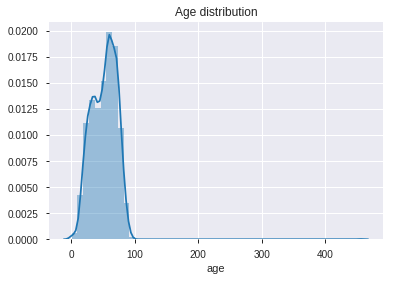

In [0]:
ax = sns.distplot(data.age.drop(data.loc[pd.isna(data.age)].index), norm_hist=True)
ax.set_title('Age distribution');

Похоже, что где-то есть выброс. Разберёмся с ним позже.

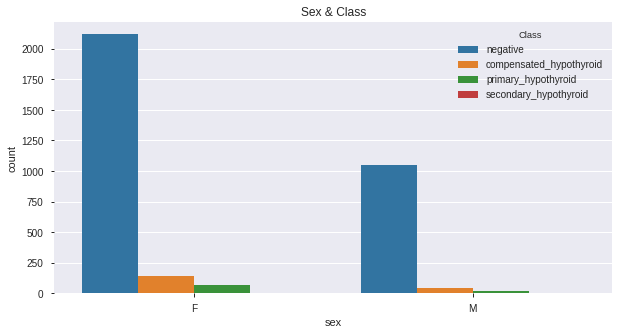

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(data.sex,hue=data.Class)
plt.title('Sex & Class')
plt.show()

Значительного перекоса по полу на первый взгляд не наблюдается.

Заменим некоторые бинарные категориальные значения:

In [0]:
data['sex'] = data['sex'].replace({'M':0, 'F':1})
data = data.replace(to_replace={'f':0,'t':1})


In [0]:
data.dtypes

age                           object
sex                          float64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
sick                           int64
pregnant                       int64
thyroid_surgery                int64
I131_treatment                 int64
query_hypothyroid              int64
query_hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH_measured                   int64
TSH                           object
T3_measured                    int64
T3                            object
TT4_measured                   int64
TT4                           object
T4U_measured                   int64
T4U                           object
FTI_measured                   int64
FTI                           object
referral_source               object
C

In [0]:
data['Class'].value_counts()

negative                   3302
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

secondary_hypothyroid представлен всего 2 экземплярами. Сделать предсказие на основе всего 2х объектов крайне сложно. Так как для этого нам требуется провести разбиение на train и test со стратификацией, а так же сделать кросс валидацию, следовательно мы просто не сможем предсказывать данный класс. Поэтому удалим их.

In [0]:
data = data.loc[data.Class != 'secondary_hypothyroid']

In [0]:
data['referral_source'].value_counts()

other    2021
SVI      1034
SVHC      385
STMW      112
SVHD       39
Name: referral_source, dtype: int64

In [0]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.3,1,2.5,1,125,1,1.14,1,109,SVHC,negative
1,23,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.1,1,2,1,102,0,NaN,0,NaN,other,negative
2,46,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.98,0,NaN,1,109,1,0.91,1,120,other,negative
3,70,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.16,1,1.9,1,175,0,NaN,0,NaN,other,negative
4,70,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.72,1,1.2,1,61,1,0.87,1,70,SVI,negative


Теперь нужно провести categorial encoding колонок Class и referral_source:

In [0]:
le = LabelEncoder()
le.fit(data.Class)
data['Class'] = le.transform(data.Class)


In [0]:
le = LabelEncoder()
le.fit(data.referral_source)
data['referral_source'] = le.transform(data.referral_source)
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.3,1,2.5,1,125,1,1.14,1,109,1,1
1,23,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.1,1,2,1,102,0,NaN,0,NaN,4,1
2,46,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.98,0,NaN,1,109,1,0.91,1,120,4,1
3,70,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.16,1,1.9,1,175,0,NaN,0,NaN,4,1
4,70,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.72,1,1.2,1,61,1,0.87,1,70,3,1


In [0]:
data.dtypes

age                           object
sex                          float64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
sick                           int64
pregnant                       int64
thyroid_surgery                int64
I131_treatment                 int64
query_hypothyroid              int64
query_hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH_measured                   int64
TSH                           object
T3_measured                    int64
T3                            object
TT4_measured                   int64
TT4                           object
T4U_measured                   int64
T4U                           object
FTI_measured                   int64
FTI                           object
referral_source                int64
C

Все колонки типа object конвертируем в numeric:

In [0]:
cols = data.columns[data.dtypes.eq('object')]
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

In [0]:
data.dtypes

age                          float64
sex                          float64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
sick                           int64
pregnant                       int64
thyroid_surgery                int64
I131_treatment                 int64
query_hypothyroid              int64
query_hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH_measured                   int64
TSH                          float64
T3_measured                    int64
T3                           float64
TT4_measured                   int64
TT4                          float64
T4U_measured                   int64
T4U                          float64
FTI_measured                   int64
FTI                          float64
referral_source                int64
C

## KNN Imputer

Заполним оставшиеся пропуски c помощью KNN:

In [0]:
from missingpy import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_values = imputer.fit_transform(data)

In [0]:
data_values

array([[ 41.,   1.,   0., ..., 109.,   1.,   1.],
       [ 23.,   1.,   0., ..., 106.,   4.,   1.],
       [ 46.,   0.,   0., ..., 120.,   4.,   1.],
       ...,
       [ 74.,   1.,   0., ..., 105.,   4.,   1.],
       [ 72.,   0.,   0., ...,  87.,   3.,   1.],
       [ 64.,   1.,   0., ...,  92.,   4.,   1.]])

In [0]:
cols = data.columns
data = pd.DataFrame(data=data_values,columns=cols)
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.300,1.0,2.50,1.0,125.0,1.0,1.140,1.0,109.0,1.0,1.0
1,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.100,1.0,2.00,1.0,102.0,0.0,0.976,0.0,106.0,4.0,1.0
2,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.980,0.0,1.62,1.0,109.0,1.0,0.910,1.0,120.0,4.0,1.0
3,70.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160,1.0,1.90,1.0,175.0,0.0,0.988,0.0,163.0,4.0,1.0
4,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.720,1.0,1.20,1.0,61.0,1.0,0.870,1.0,70.0,3.0,1.0
5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.030,0.0,2.72,1.0,183.0,1.0,1.300,1.0,141.0,4.0,1.0
6,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.760,0.0,1.94,1.0,72.0,1.0,0.920,1.0,78.0,4.0,1.0
7,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.200,1.0,0.60,1.0,80.0,1.0,0.700,1.0,115.0,3.0,1.0
8,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.600,1.0,2.20,1.0,123.0,1.0,0.930,1.0,132.0,3.0,1.0
9,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.400,1.0,1.60,1.0,83.0,1.0,0.890,1.0,93.0,3.0,1.0


In [0]:
data['sex'].value_counts()

1.0    2360
0.0    1115
0.8      67
0.6      32
0.4      15
0.2       2
Name: sex, dtype: int64

In [0]:
data['sex'] = round(data['sex'])

In [0]:
data['sex'].value_counts()

1.0    2459
0.0    1132
Name: sex, dtype: int64

In [0]:
sum(data.isna().sum())

0

## Hist

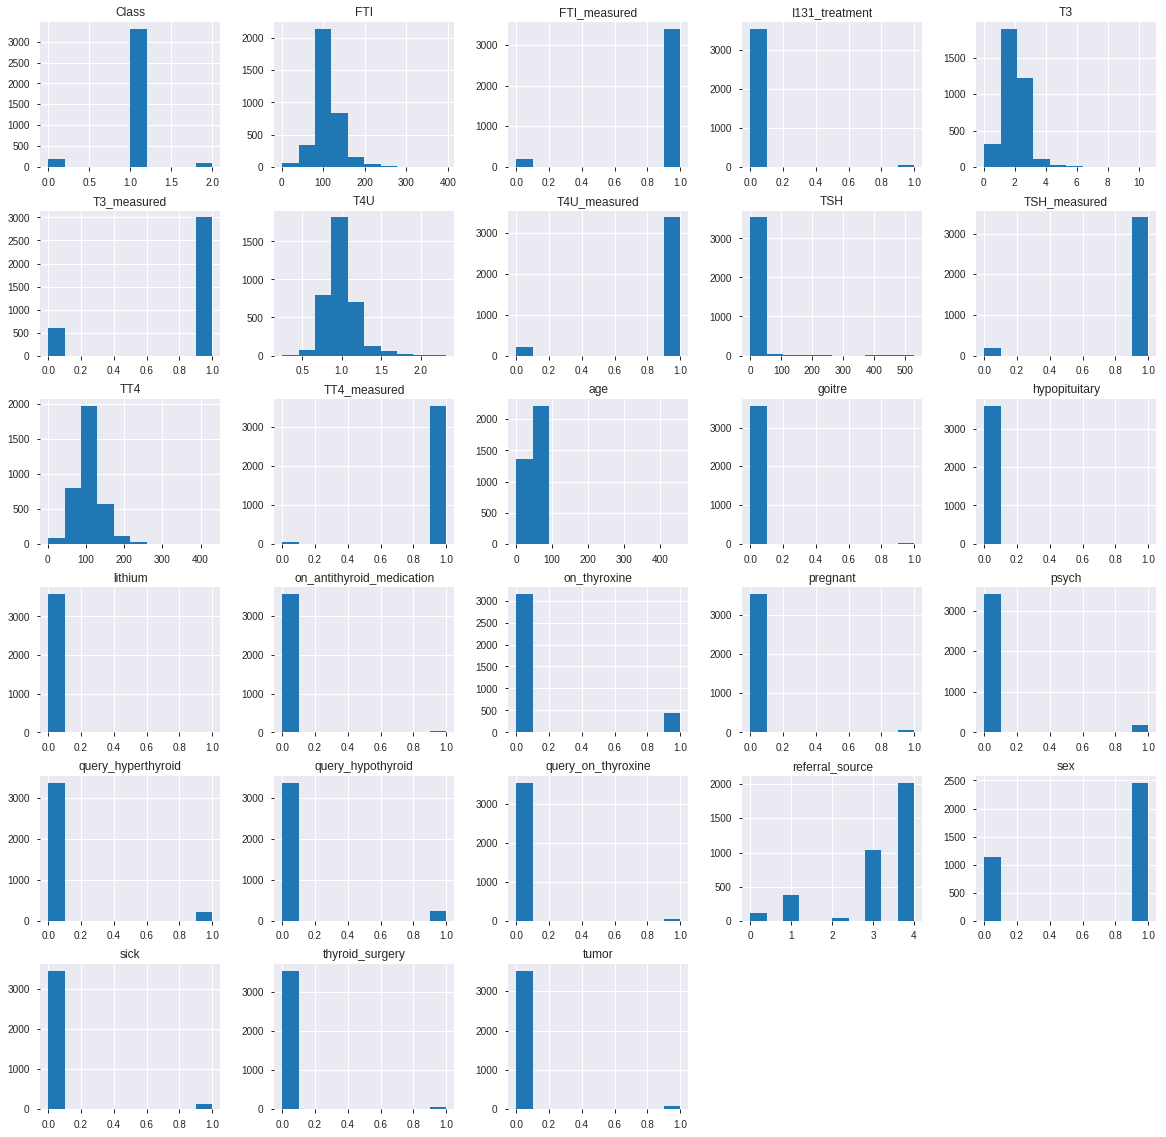

In [0]:
data.hist(figsize = (20,20))
plt.show()

In [0]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'referral_source', 'Class'],
      dtype='object')

## Profile report

In [0]:
profile_report = ProfileReport(data)
profile_report

Number of variables,28
Number of observations,3591
Total Missing (%),0.0%
Total size in memory,785.6 KiB
Average record size in memory,224.0 B
Numeric,8
Categorical,0
Boolean,19
Date,0
Text (Unique),0
Rejected,1


Из ProfileReport мы видим:

FTI_measured is highly correlated with T4U_measured (ρ = 0.99489) Rejected

Dataset has 1 duplicate rows Warning


Разберёмся с этим:

In [0]:
data.drop_duplicates(inplace=True)

In [0]:
data.drop(columns=['FTI_measured'], inplace=True)

А также заметим, что наша таргетная переменная плохо коррелирует со всеми признаками.

In [0]:
numerical_features = ['TT4', 'age', 'T4U', 'T3', 'FTI']
categorical_features = list(set(data.columns).difference(numerical_features))

## Outliers detection

Удалим людей с аномальным возрастом.

In [0]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [0]:
data.shape

(3590, 27)

In [0]:
data = remove_outlier(data,'age')
data = remove_outlier(data,'TT4')
data = remove_outlier(data,'T4U')
data = remove_outlier(data,'T3')
data = remove_outlier(data,'FTI')

In [0]:
data.shape

(3479, 27)

Посмотрим на вид распределения численных переменных.

In [0]:
def qq_plotting(column):
    plt.figure(figsize=(4,2))
    fig=qqplot(column,line='45',fit='True')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Theoretical quantiles",fontsize=12)
    plt.ylabel("Sample quantiles",fontsize=12)
    plt.title("Q-Q plot of "+column.name, fontsize=14)
    plt.show()

<Figure size 400x200 with 0 Axes>

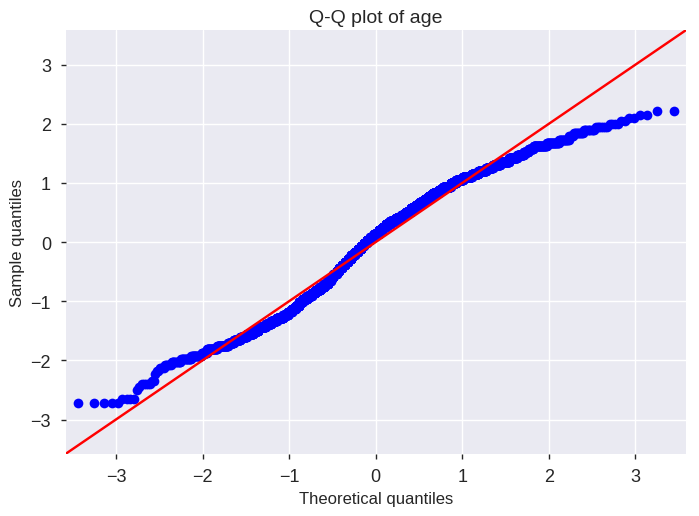

<Figure size 400x200 with 0 Axes>

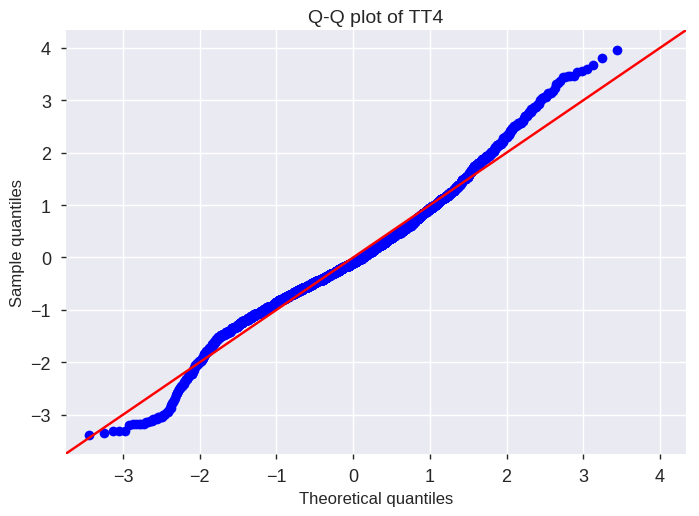

<Figure size 400x200 with 0 Axes>

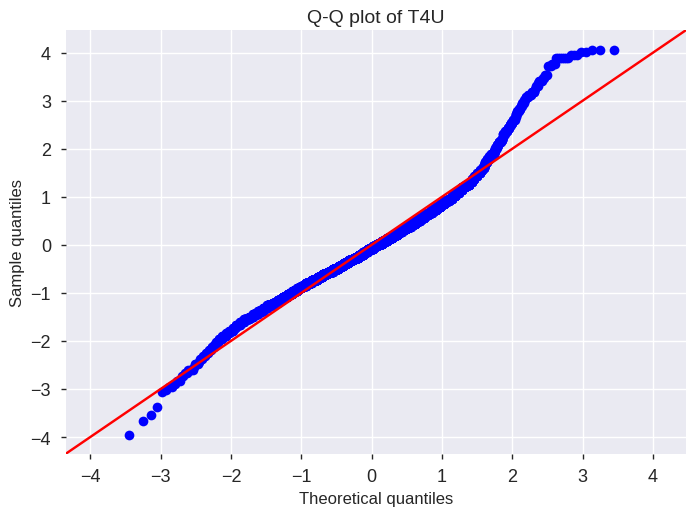

<Figure size 400x200 with 0 Axes>

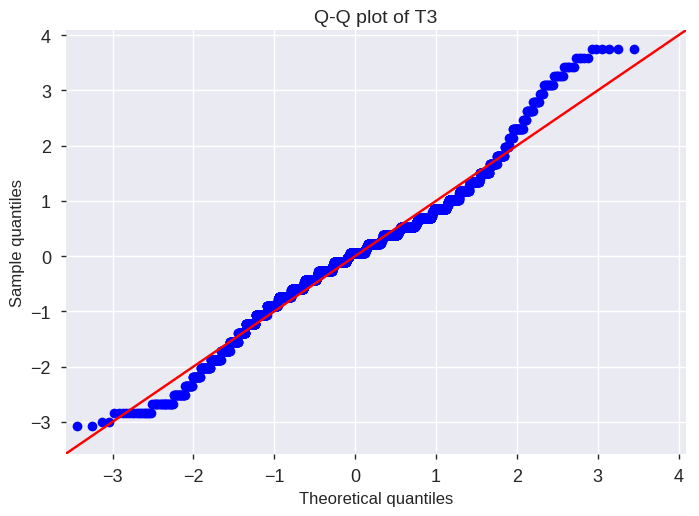

<Figure size 400x200 with 0 Axes>

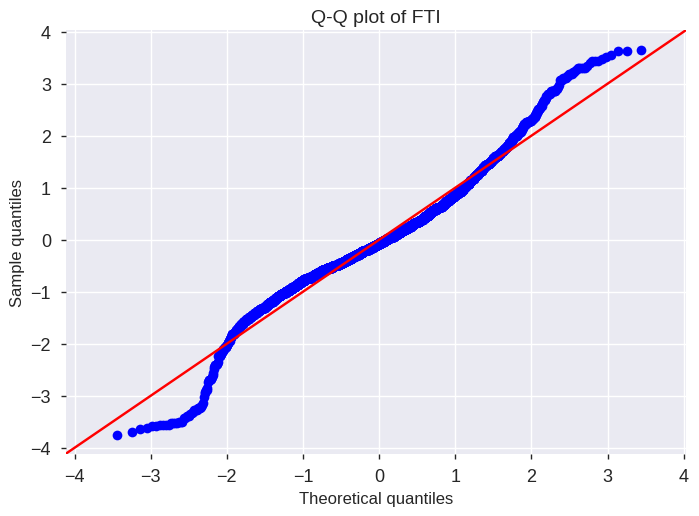

In [0]:
qq_plotting(data.age)
qq_plotting(data.TT4)
qq_plotting(data.T4U)
qq_plotting(data.T3)
qq_plotting(data.FTI)

Распределение всех численных признаков близко к нормальному.

## Train-test creation

In [0]:
def split(data):
  X = data.drop('Class', axis=1)
  y = data['Class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = split(data)

# Models

## Logistic Regression with regularization

Так как у нас задача многоклассовой классификации, будем пользоваться f1 score, а именно weighted average, который показывает взвешенный средний f1 score для каждого из классов.

In [0]:
my_scorer = make_scorer(f1_score, average='weighted')
skv = StratifiedKFold(5)

In [0]:
tuned_parameters = [{'C': [0.1, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2)

clf.fit(X_train.values, y_train)
y_pred = clf.predict(X_test.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=5 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.0s finished


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.66      0.75        58
         1.0       0.98      0.99      0.99       959
         2.0       0.68      0.85      0.75        27

    accuracy                           0.97      1044
   macro avg       0.84      0.83      0.83      1044
weighted avg       0.97      0.97      0.97      1044



Наша модель имеет высокий recall для каждого из классов:

*   negative (1) 
*   primary_hypothyroid (2)  

То есть "здоровых" и "крайней степени больных" мы находим с высокой долей вероятности.

В случае с классом compensated_hypothyroid (0) recall = 0.66. Это означает, что мы нашли 66% из всех людей c данным диагнозом. Не самый лучший результат. Попробуем другие модели.

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.statisticssolutions.com/wp-content/uploads/2017/12/rachnovblog.jpg")

## Logistic Regression without regularization

In [0]:
%%time

tuned_parameters = [{'C': [100000000]}]

clf = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2)

clf.fit(X_train.values, y_train)
y_pred = clf.predict(X_test.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] C=100000000 .....................................................
[CV] ...................................... C=100000000, total=   0.1s
[CV] C=100000000 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... C=100000000, total=   0.2s
[CV] C=100000000 .....................................................
[CV] ...................................... C=100000000, total=   0.1s
[CV] C=100000000 .....................................................
[CV] ...................................... C=100000000, total=   0.1s
[CV] C=100000000 .....................................................
[CV] ...................................... C=100000000, total=   0.1s
CPU times: user 801 ms, sys: 2.79 ms, total: 804 ms
Wall time: 802 ms


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76        58
         1.0       0.98      0.99      0.99       959
         2.0       0.66      0.85      0.74        27

    accuracy                           0.97      1044
   macro avg       0.83      0.84      0.83      1044
weighted avg       0.97      0.97      0.97      1044



Логистическая регрессия с регуляризацией и без дает близкие результаты.

## KNN Classifier

In [0]:
%%time

tuned_parameters = [{'n_neighbors': np.arange(1,10)}]

clf = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.6s finished


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.47      0.56        58
         1.0       0.97      0.99      0.98       959
         2.0       0.88      0.81      0.85        27

    accuracy                           0.95      1044
   macro avg       0.85      0.76      0.79      1044
weighted avg       0.95      0.95      0.95      1044



Результат knn заметно хуже логистической регрессии.

## Pipeline

То, что мы сделали выше можно объединить в pipeline:

In [0]:
my_scorer = make_scorer(f1_score, average='weighted')
skv = StratifiedKFold(5)

In [0]:
clf = LogisticRegression()

In [0]:
pipe = Pipeline(steps=[('clf', clf)])

In [0]:
params = [ 
  {'clf': [LogisticRegression(random_state=42, class_weight='balanced')],
  'clf__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 1000, 5000, 10000, 1000000]},
  {'clf': [KNeighborsClassifier(algorithm='kd_tree')],
  'clf__n_neighbors': np.arange(1,20)}
]

In [0]:
grid_search = GridSearchCV(pipe, param_grid=params, scoring=my_scorer, cv=skv)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77        58
         1.0       0.98      0.99      0.99       959
         2.0       0.66      0.85      0.74        27

    accuracy                           0.97      1044
   macro avg       0.84      0.84      0.83      1044
weighted avg       0.97      0.97      0.97      1044



# Scaling

In [0]:
scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]

In [0]:
for i in scalers:
  data1=data.copy().reset_index()
  numericals_scaled = pd.DataFrame(
    i.fit_transform(data1[numerical_features]),
    columns=numerical_features
  )
  data1.drop(columns=numerical_features,inplace=True)
  data1 = pd.concat([data1,numericals_scaled],axis=1)
  X_train, X_test, y_train, y_test = split(data1)
  grid_search.fit(X_train, y_train)
  y_pred = grid_search.predict(X_test)
  print(f1_score(y_test, y_pred, average='macro'))

0.8151509652844983
0.8280600696809377
0.8235993545844074
0.7940103751830397


Лучше всего себя показывает MinMaxScaler. Однако, без него модель показывала результат лучше.

# Target balancers

## Under-sampling

In [0]:
from imblearn.under_sampling import RandomUnderSampler
random_undersampler = RandomUnderSampler(random_state=0)

In [0]:
X_resampled, y_resampled = random_undersampler.fit_resample(
    data[numerical_features + categorical_features],
    data.Class
)

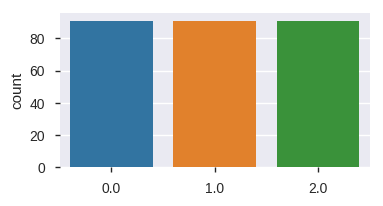

In [0]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y_resampled)
plt.show()

In [0]:
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.07499976330722032


UnderSampling явно ухудшает результат, путем выкидывания большей части данных.

## Over-sampling

### RandomOverSampler

In [0]:
X_train, X_test, y_train, y_test = split(data)

In [0]:
random_oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = random_oversampler.fit_resample(
    X_train,
    y_train
)

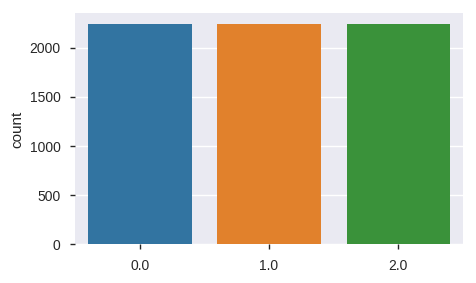

In [0]:
plt.figure(figsize=(5, 3))
sns.countplot(x=y_resampled)
plt.show()

In [0]:
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.7868224485664091


### ADASYN

In [0]:
data1=data.copy()
X_train, X_test, y_train, y_test = split(pd.concat([data1[numerical_features],data1['Class']],axis=1))

In [0]:
adasyn_oversampler = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn_oversampler.fit_resample(
    X_train,
    y_train
)

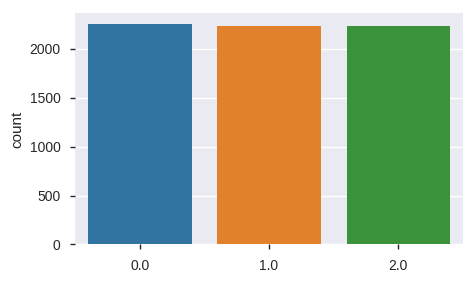

In [0]:
plt.figure(figsize=(5, 3))
sns.countplot(x=y_resampled)
plt.show()

In [0]:
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.5179010087745161


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.11      0.40      0.17        58
         1.0       0.95      0.77      0.85       959
         2.0       0.38      0.85      0.53        27

    accuracy                           0.75      1044
   macro avg       0.48      0.67      0.52      1044
weighted avg       0.89      0.75      0.81      1044



### SMOTE


In [0]:
smote_oversampler = SMOTE(random_state=42,sampling_strategy='not minority',kind='svm')
X_resampled, y_resampled = smote_oversampler.fit_resample(
    X_train,
    y_train
)

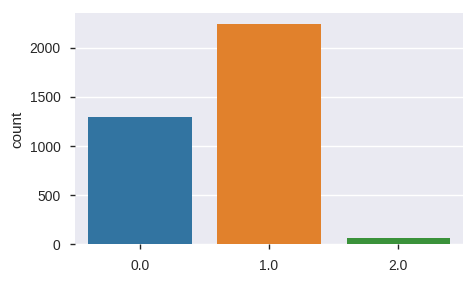

In [0]:
plt.figure(figsize=(5, 3))
sns.countplot(x=y_resampled)
plt.show()

In [0]:
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.5790682199969458


Были перебраны различные гиперпараметры для SMOTE и ADASYN. Например, такие как: sampling_strategy, k_neighbors, kind и т.п.
В итоге они не помогают улучшить macro avg, а только значительно ухудшают его.

# Feature Engineering

In [0]:
import scipy.stats as ss
funcs = ['mean']
groups = ['on_thyroxine','sex']
def FE(columns):
    for i in columns:
        for j in groups:
            for k in funcs:
                data[k+'_'+i+'_'+'by'+'_'+j] = data[i].groupby(data[j]).transform(k)    

In [0]:
FE(['TSH','T3','TT4'])

In [0]:
X_train, X_test, y_train, y_test = split(data)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.8284447732651793


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77        58
         1.0       0.98      0.99      0.99       959
         2.0       0.64      0.85      0.73        27

    accuracy                           0.97      1044
   macro avg       0.83      0.84      0.83      1044
weighted avg       0.97      0.97      0.97      1044



В целом, модель показывает себя очень хорошо в ключе определения здоровых людей. А также приемлемо в поиске "больных". Попробуем улучшить score несколько более продвинутой моделью.

# LGB Model

In [0]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
lgb_model = model.fit(X_train,y_train)    
y_pred = lgb_model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.9788616954021615


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        58
         1.0       1.00      1.00      1.00       959
         2.0       0.90      1.00      0.95        27

    accuracy                           1.00      1044
   macro avg       0.97      0.99      0.98      1044
weighted avg       1.00      1.00      1.00      1044



## Hyperopt

Попробуем подобрать гиперпараметры с помощью Hyperopt:

In [0]:
from hyperopt.fmin import fmin
from hyperopt import hp, tpe
from sklearn.model_selection import cross_val_score
hp_space ={     'num_leaves' : 31,
                'max_depth': -1,
                'min_child_samples': 1 + hp.randint('min_child_samples', 40),
                'subsample_for_bin': 200000,
                'n_estimators': 100,
                'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.0001),
                'lambda_l1' : 0,
                'lambda_l2' : 0,
                'learning_rate' : hp.quniform('learning_rate', 0.001, 0.1, 0.001),
                'boosting_type' : 'gbdt',
                'subsample_freq' : 0 + hp.randint('subsample_freq',10),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.001),
                'min_child_weight' : hp.quniform('min_child_weight', 0.001, 0.01, 0.001),
                'bagging_fraction ' : hp.quniform('bagging_fraction ', 0.0001, 1, 0.001)
            }
def hyperopt_lgb_score(params):
    lgbr = lgb.LGBMClassifier(**params)
    current_score = cross_val_score(lgbr, X_train, y_train, scoring='f1_macro', cv=3).mean()
    print(-current_score, params)
    return -current_score

fmin работает длительное время, поэтому я сразу напишу результат.

In [0]:
#best = fmin(fn=hyperopt_lgb_score, space=hp_space, algo=tpe.suggest, max_evals=500,verbose=-1)

In [0]:
best = {
       'bagging_fraction ': 0.558, 'boosting_type': 'gbdt', 'colsample_bytree': 0.865,
       'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.059000000000000004,
       'max_depth': -1, 'min_child_samples': 35, 'min_child_weight': 0.009000000000000001,
       'min_split_gain': 0.0028, 'n_estimators': 100, 'num_leaves': 31,
       'subsample_for_bin': 200000, 'subsample_freq': 1
       }


In [0]:
import lightgbm as lgb
model = lgb.LGBMClassifier(**best)
lgb_model = model.fit(X_train,y_train)    
y_pred = lgb_model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.9789105161155979


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        58
         1.0       1.00      1.00      1.00       959
         2.0       0.90      1.00      0.95        27

    accuracy                           1.00      1044
   macro avg       0.96      1.00      0.98      1044
weighted avg       1.00      1.00      1.00      1044



Нам удалось еще немного улучшить score с помощью библиотеки Hyperopt, путем подбора гиперпараметров.

## A bit more feature engineering

In [0]:
X_train, X_test, y_train, y_test = split(data)

In [0]:
def brute_feat_gen(df, num_col_names):
    for name1 in (num_col_names):
        for name2 in num_col_names:
            df[name1 + "_X_" + name2] =  df[name1] * df[name2]
        df[name1 + "_powers3" ] =  np.power(df[name1], 3)
    return df

In [0]:
X_train_2_fg = brute_feat_gen(X_train, numerical_features)
X_test_2_fg = brute_feat_gen(X_test, numerical_features)

In [0]:
%%time

clf = lgb.LGBMClassifier(**best)
clf.fit(np.hstack([X_train.values, X_train_2_fg.values]), y_train)

CPU times: user 1.33 s, sys: 16.8 ms, total: 1.34 s
Wall time: 688 ms


In [0]:
y_pred = clf.predict(np.hstack([X_test.values, X_test_2_fg.values]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        58
         1.0       1.00      1.00      1.00       959
         2.0       0.90      1.00      0.95        27

    accuracy                           1.00      1044
   macro avg       0.96      0.99      0.98      1044
weighted avg       1.00      1.00      1.00      1044



In [0]:
print(f1_score(y_test, y_pred, average='macro'))

0.9758386918949485


LGB модель умеет не только определять здорового человека в 100% случаев на нашем тестовом множестве, но и с крайне высокой вероятностью находит "больных"!